# Analysis of epistasis in Kd datasets

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

import sys
sys.path.append("../")
from utils import *
from global_variables import *
import matplotlib as mpl

mpl.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "axes.linewidth": 0.8,
    "lines.linewidth": 1.0,
    "font.size": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "font.family": "serif",
    "mathtext.fontset": "stix",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

pgm_path = '../PGM/'
sys.path.append(pgm_path + 'source/')
sys.path.append(pgm_path + 'utilities/')
import Proteins_utils, rbm, RBM_utils

E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors
Loaded 438 KD vectors


In [2]:
BA1='NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVSGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYSFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKST'
BA1_SEQ=Proteins_utils.seq2num(BA1)[:,BEGIN:-END]

In [3]:
BA1_SEQ.shape

(1, 178)

In [4]:

log_kd_values=get_Kd(BA1_SEQ[0],WT_KD_VECTORS , log10=True) 
ab_names=list(WT_KD_VECTORS.keys())
log_kd_values.shape#in the order of ab names

(438,)

In [5]:
ic50_db_base=pd.read_csv('../exp_data/cao_data/antibody_ic50s.csv',index_col=0)
ic50_db_base=ic50_db_base[ic50_db_base['virus']=='BA.1']
ic50_db_base['antibody'] = ic50_db_base.index
ic50_db_base#look for IC50 values

,virus,IC50,antibody
antibody,,,
BD30-604,BA.1,0.28500,BD30-604
BD45-21,BA.1,7.12000,BD45-21
BD45-70,BA.1,10.00000,BD45-70
BD45-105,BA.1,2.56000,BD45-105
BD45-145,BA.1,0.06280,BD45-145
...,...,...,...
BD55-6727,BA.1,4.37000,BD55-6727
BD55-6728,BA.1,10.00000,BD55-6728
BD55-6729,BA.1,10.00000,BD55-6729


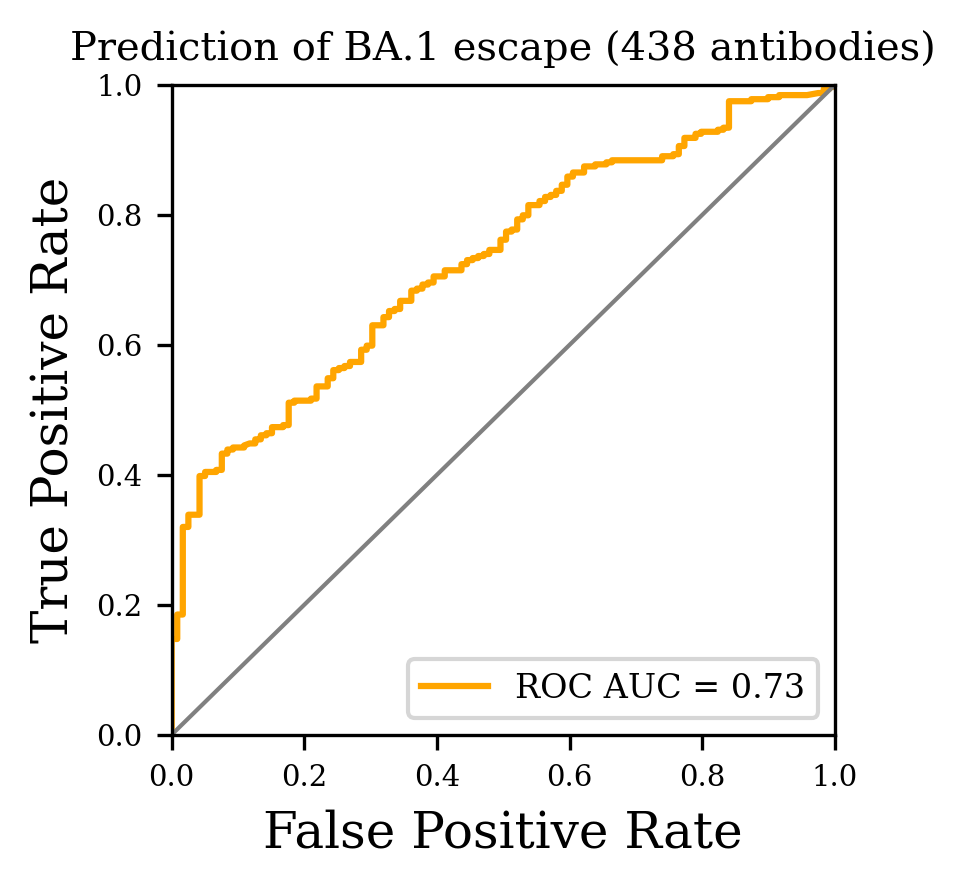

[Info] Using IC50 column: 'IC50'
[Info] Positives: 319 of 438 (threshold IC50 ≥ 10)


In [6]:



df_kd = pd.DataFrame({
    "antibody": ab_names,
    "log_kd": np.asarray(log_kd_values, dtype=float)
})

def _norm(s):
    return str(s).strip().lower().replace(" ", "").replace("-", "").replace("_", "")

df_kd["key"] = df_kd["antibody"].map(_norm)

# ----------------------------
# Filter BA.1 and find IC50 column
# ----------------------------
ic50_df = ic50_db_base.copy()

ic50_df["key"] = ic50_df["antibody"].map(_norm)

cands = [c for c in ic50_df.columns if "ic50" in c.lower()]
if not cands:
    num_cols = [c for c in ic50_df.select_dtypes(include=[np.number]).columns]
    if not num_cols:
        raise ValueError("No numeric IC50-like column found in ic50_db_base.")
    ic50_col = num_cols[0]
else:
    ic50_col = cands[0]


merged = (
    df_kd.merge(ic50_df[["key", ic50_col, "antibody"]], on="key", how="inner", suffixes=("_kd", "_ic50"))
)
merged = merged[np.isfinite(merged[ic50_col]) & (merged[ic50_col] > 0)].copy()

y_true = (merged[ic50_col].values >= 10).astype(int)   # positive if IC50 >= 10
y_score = merged["log_kd"].values                      # higher log_kd => predict positive


fpr, tpr, _ = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)


# ----------------------------
# Plot ROC
# ----------------------------
plt.figure(figsize=(3, 3), dpi=300)
plt.plot(fpr, tpr, lw=1.5, label=f"ROC AUC = {auc:.2f}", color='orange')
plt.plot([0, 1], [0, 1], lw=1.0, color='grey')  # diagonal

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)

plt.title("Prediction of BA.1 escape ("+str(len(y_true))+" antibodies)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ----------------------------
# Sanity report
# ----------------------------
missing = set(df_kd["key"]) - set(ic50_df["key"])
if missing:
    print(f"[Info] {len(missing)} KD antibodies had no BA.1 IC50 match by normalized name. "
          f"Examples: {list(sorted(missing))[:5]}")
print(f"[Info] Using IC50 column: '{ic50_col}'")
print(f"[Info] Positives: {y_true.sum()} of {len(y_true)} (threshold IC50 ≥ 10)")
